In [1]:
# Import Required Packages
import numpy as np
import math
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import SimpleITK as sitk
from scipy import ndimage
import glob
import pandas as pd

In [15]:
# Downloaded Packages
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn
from torch.nn import BCELoss
import segmentation_models_pytorch as smp
import torch.optim as optim
import shutil


# Custom written .py files
from helper import ground_truth_files, mask_images
from clubfoot_transforms import *
from pytorchclubfootdataset import *
from clubfoot_training import *

base_dir = 'C:\\Users\\danie\\OneDrive\\Documents\\Clubfoot\\GroundTruthSegmentation\\Final_Seg_Maps_NIFTI2'

In [16]:
print(os.getcwd())
base = os.path.join(base_dir, 'Data')
data = ground_truth_files(base, clubfoot_type = None) # clubfoot_type = 'AP','LAT' 

C:\Users\danie\OneDrive\Documents\Clubfoot\GroundTruthSegmentation\Final_Seg_Maps_NIFTI2\Data


In [17]:
data.head()

,folder,nifti_path,bmp_background,vtk_path
0,1,C:\Users\danie\OneDrive\Documents\Clubfoot\Gro...,C:\Users\danie\OneDrive\Documents\Clubfoot\Gro...,C:\Users\danie\OneDrive\Documents\Clubfoot\Gro...
1,10,C:\Users\danie\OneDrive\Documents\Clubfoot\Gro...,C:\Users\danie\OneDrive\Documents\Clubfoot\Gro...,C:\Users\danie\OneDrive\Documents\Clubfoot\Gro...
2,12,C:\Users\danie\OneDrive\Documents\Clubfoot\Gro...,C:\Users\danie\OneDrive\Documents\Clubfoot\Gro...,C:\Users\danie\OneDrive\Documents\Clubfoot\Gro...
3,13,C:\Users\danie\OneDrive\Documents\Clubfoot\Gro...,C:\Users\danie\OneDrive\Documents\Clubfoot\Gro...,C:\Users\danie\OneDrive\Documents\Clubfoot\Gro...
4,14,C:\Users\danie\OneDrive\Documents\Clubfoot\Gro...,C:\Users\danie\OneDrive\Documents\Clubfoot\Gro...,C:\Users\danie\OneDrive\Documents\Clubfoot\Gro...


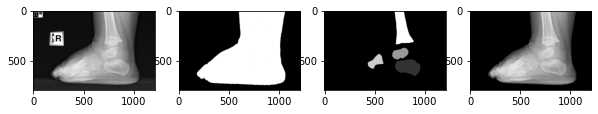

In [38]:
mask_images(data, 233)

In [19]:
os.chdir(base_dir)
# Training, Test, and Validation
split = pd.read_csv('Clubfoot_Update_012521.csv')

split['Folder ID'] = split['Folder ID'].astype(str)
data_2 = data.merge(split, left_on='folder', right_on='Folder ID', how='inner')
data_2 = data_2.drop(columns = ['Folder ID'])

training_data = data_2[data_2['Split'] == 'Training']
validation_data = data_2[data_2['Split'] == 'Validation']
validation_data = validation_data.reset_index()

# Clubfoot_Update_012521
print(' The training data size is: ', len(training_data),'\n',
      'The validation data size is: ', len(validation_data), '\n')

 The training data size is:  274 
 The validation data size is:  50 



## Functions for Calculating Angles

In [7]:
def axis_finder(img):
    '''
    Function to return the long and short axis through 
    the center of a blob
    '''
    y, x = np.nonzero(img)
    x = x - np.mean(x)
    y = y - np.mean(y)
    coords = np.vstack([x, y])
    cov = np.cov(coords)
    evals, evecs = np.linalg.eig(cov)
    sort_indices = np.argsort(evals)[::-1]
    x_v1, y_v1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
    x_v2, y_v2 = evecs[:, sort_indices[1]]
    return [x_v1, y_v1, x_v2, y_v2, x, y]

In [8]:
def angle_vector(vector_1, vector_2):
    '''
    Function that calculates the angle (in degrees)
    between any two input vectors
    '''
    unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
    unit_vector_2 = vector_2 / np.linalg.norm(vector_2)
    dot_product = np.dot(unit_vector_1, unit_vector_2)
    angle = np.arccos(dot_product)
    return(math.degrees(angle))

In [9]:
def plot_axis(eigen_data, scale):
    '''
    The plots the long (red) and short (axis)
    of a blob
    '''
    plt.plot([eigen_data[0]*-scale*10, eigen_data[0]*scale*10],
             [eigen_data[1]*-scale*10, eigen_data[1]*scale*10], color='red')
    plt.plot([eigen_data[2]*-scale*5, eigen_data[2]*scale*5],
             [eigen_data[3]*-scale*5, eigen_data[3]*scale*5], color='blue')
    plt.plot(eigen_data[4], eigen_data[5], 'k.')
    plt.axis('equal')
    plt.gca().invert_yaxis()  # Match the image system with origin at top left
    plt.show()

In [10]:
def sub_plot(eigen_data, scale, x, y, col):
    plt.plot([eigen_data[0]*-scale*10 + x, eigen_data[0]*scale*10 + x],
             [eigen_data[1]*-scale*10 + y, eigen_data[1]*scale*10 + y], color=col)  

In [11]:
def two_point_unit(bone1, bone2):
    pt1 = ndimage.measurements.center_of_mass(bone1)[0], ndimage.measurements.center_of_mass(bone1)[1]
    pt2 = ndimage.measurements.center_of_mass(bone2)[0], ndimage.measurements.center_of_mass(bone2)[1]
    
    distance = [pt1[0] - pt2[0],
               pt1[1] - pt2[1]]
    
    norm = math.sqrt(distance[1] ** 2 + distance[0] ** 2)
    direction = [distance[1] / norm, distance[0] / norm]
    return direction

In [12]:
def input_image(label):
    # Grabbing labeled bones from the gorund truth image
    b = (label == 1) # calcanues
    c = (label == 2) # calcaneus-talus overlap 
    d = (label == 3) # talus
    first_metatarsel = (label == 4) # 1st metatarsel
    tibia = (label == 5) # tibia
    cuboid= (label == 6) # cuboid
    cuboid_overlap = (label == 7).astype(int) # cuboid
    calcaneus = b.astype(int) + c.astype(int) # Calcanues
    talus = c.astype(int) + d.astype(int) # Talus
    cuboid = cuboid_overlap + cuboid
    return (first_metatarsel, tibia, cuboid, calcaneus, talus)

## Changing Directory

In [13]:
print(os.getcwd())
base_dir = os.path.join(os.getcwd(), 'Results','AngleMeasures')
os.chdir(base_dir)

C:\Users\danie\OneDrive\Documents\Clubfoot\GroundTruthSegmentation\Final_Seg_Maps_NIFTI2


## AP Angle Calcualations

Pick a number between 0 - 50
The x, y resolution is 0.15 , 0.15
LAT Image


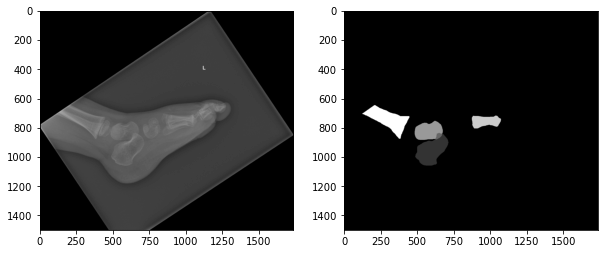

In [14]:
# Picking a number to pull the ground truth data and dimensions
print('Pick a number between 0 -', len(validation_data))
num = 13
image = sitk.ReadImage(validation_data['nifti_path'].iloc[num])
spacing = image.GetSpacing() #0.1389 mm
print("The x, y resolution is %.2f" % spacing[0],", %.2f" % spacing[1] )
nifti = sitk.GetArrayViewFromImage(image)

vtk = sitk.ReadImage(validation_data['vtk_path'].iloc[num])
vtk_arr = sitk.GetArrayViewFromImage(vtk)
first_metatarsel, tibia, cuboid, calcaneus, talus = input_image(vtk_arr)

f, axarr = plt.subplots(1,2, figsize = (10,10)) 
axarr[0].imshow(nifti[0,], cmap='gray') # [0,]
axarr[1].imshow(vtk_arr, cmap='gray')

type_im = validation_data['nifti_path'].iloc[num].split('\\')[-1]
if 'AP' in type_im:
    print('AP Image')
if 'LAT' in type_im:
    print('LAT Image')

In [15]:
# Angle 
def shortest_distance(x1, y1, a, b, c):  
    d = abs((a * x1 + b * y1 + c)) / (math.sqrt((a * a) + (b * b))) 
    return d

def AP_calculations(image, vtk, im_name, spacing, folder):
    first_metatarsel, tibia, cuboid, calcaneus, talus = input_image(vtk)
    # Angle 1:
    # 1) Find the long axis of the talus
    talus_data = axis_finder(talus)
    # 2) Line between the midpoint of the talus and the 1st metatarsel
    direction = two_point_unit(first_metatarsel, talus)
    # Angle 
    talo_meta_angle = angle_vector(direction, talus_data[:2])
    #print('The Talo-1st Metatarsel Angle is: {a:8.2f} degrees'.format(a = talo_meta_angle))
    
    # 2: Angle between the:
    # 1) Find the long axis of the talus
    # 2) Line between the midpoint of the talus and the 1st metatarsel
    calcaneus_data = axis_finder(calcaneus)
    # Angle 
    talo_calc_angle = angle_vector(talus_data[:2], calcaneus_data[:2])
    #print('The Talus-calcaneal Angle is: {a:8.2f} degrees'.format(a = talo_calc_angle))
    
    # Measurement 1:
    #calcanues_data = axis_finder(calcaneus)
    angle = math.degrees(math.atan(calcaneus_data[1]/calcaneus_data[0]))
    radians = math.radians(angle + 90)
    calcaneus_data_90 = [math.cos(radians), math.sin(radians)] # x, y
    
    # 2) Find the midpoint of the cuboid
    cuboid_cms = ndimage.measurements.center_of_mass(cuboid)
    pix_dist = shortest_distance(cuboid_cms[1], cuboid_cms[0], 
                                 calcaneus_data[0], calcaneus_data[1], 0)

    angle1 = angle_vector(calcaneus_data[:2], calcaneus_data_90[:2])

    #print('The Talus-calcaneal Angle is: {a:8.2f} degrees'.format(a = angle1))
    #print("Perpendicular distance in pixels is", round(pix_dist, 2))
    #print("Perpendicular distance is", round((pix_dist * spacing[0]),3), 'mm')
    
    # Plot
    plt.rcParams['figure.figsize'] = [12, 8]
    sub_plot(talus_data, 10, 
             ndimage.measurements.center_of_mass(talus)[1],
             ndimage.measurements.center_of_mass(talus)[0], 'red')
    sub_plot(direction, 20, 
             ndimage.measurements.center_of_mass(talus)[1],
             ndimage.measurements.center_of_mass(talus)[0], 'red')
    sub_plot(talus_data, 10, 
             ndimage.measurements.center_of_mass(calcaneus)[1],
             ndimage.measurements.center_of_mass(calcaneus)[0], 'yellow')
    sub_plot(calcaneus_data, 30, 
             ndimage.measurements.center_of_mass(calcaneus)[1],
             ndimage.measurements.center_of_mass(calcaneus)[0], 'yellow')
    sub_plot(calcaneus_data_90, 3, cuboid_cms[1], cuboid_cms[0], 'blue')

    plt.imshow(image[0,], cmap='gray')
    plt.gca()#.invert_yaxis()  # Match the image system with origin at top left
    plt.savefig(im_name)
    plt.clf()
    return [folder, im_name, talo_meta_angle, talo_calc_angle, round((pix_dist * spacing[0]),3)]

def LAT_calculations(image, vtk, im_name, spacing, folder):
    first_metatarsel, tibia, cuboid, calcaneus, talus = input_image(vtk)
    # Angle 1:
    # 1) Find the long axis of the talus
    talus_data = axis_finder(talus)
    # 2) Line between the midpoint of the talus and the 1st metatarsel
    direction = two_point_unit(first_metatarsel, talus)
    # Angle 
    talo_meta_angle = angle_vector(talus_data[:2], direction)
    #print('The Talus-1st Metatarsel Angle is: {a:8.2f} degrees'.format(a = talo_meta_angle))

    # Angle 2
    # 1) Find the long axis of the talus
    talus_data = axis_finder(talus)
    # 2) Line between the midpoint of the talus and the 1st metatarsel
    calcaneus_data = axis_finder(calcaneus)
    # Angle 
    talo_calc_angle = angle_vector(talus_data[:2], calcaneus_data[:2])
    #print('The Talus-calcaneal Angle is: {a:8.2f} degrees'.format(a = talo_calc_angle))

    # Angle 3
    # 1: Angle between the tibia and the calcaneus:
    # 1) Find the long axis of the talus
    tibia_data = axis_finder(tibia)
    # 2) Line between the midpoint of the talus and the 1st metatarsel
    calcaneus_data = axis_finder(calcaneus)
    # Angle 
    tib_calc_angle = angle_vector(tibia_data[:2], calcaneus_data[:2])
    #print('The Tbial-calcaneal Angle is: {a:8.2f} degrees'.format(a = tib_calc_angle))

    # Plot
    plt.rcParams['figure.figsize'] = [12, 8]
    sub_plot(talus_data, 35, 
             ndimage.measurements.center_of_mass(talus)[1],
             ndimage.measurements.center_of_mass(talus)[0], 'red')
    sub_plot(direction, 35, 
             ndimage.measurements.center_of_mass(talus)[1],
             ndimage.measurements.center_of_mass(talus)[0], 'red')
    sub_plot(talus_data, 10, 
             ndimage.measurements.center_of_mass(calcaneus)[1],
             ndimage.measurements.center_of_mass(calcaneus)[0], 'yellow')
    sub_plot(calcaneus_data, 30, 
             ndimage.measurements.center_of_mass(calcaneus)[1],
             ndimage.measurements.center_of_mass(calcaneus)[0], 'yellow')

    sub_plot(tibia_data, 30, 
         ndimage.measurements.center_of_mass(tibia)[1],
         ndimage.measurements.center_of_mass(tibia)[0], 'blue')
    sub_plot(calcaneus_data, 10, 
         ndimage.measurements.center_of_mass(tibia)[1],
         ndimage.measurements.center_of_mass(tibia)[0], 'blue')

    plt.imshow(image[0,], cmap='gray')
    plt.gca()#.invert_yaxis()  # Match the image system with origin at top left
    plt.savefig(im_name)
    plt.clf()
    return [folder, im_name, talo_meta_angle, talo_calc_angle, tib_calc_angle]

In [16]:
measures_AP = []
measures_LAT = []

for num in range(len(validation_data)):
    type_im = validation_data['nifti_path'].iloc[num].split('\\')[-1]
    if 'AP' in type_im:
        image = sitk.ReadImage(validation_data['nifti_path'].iloc[num])
        nifti = sitk.GetArrayViewFromImage(image)

        vtk = sitk.ReadImage(validation_data['vtk_path'].iloc[num])
        vtk_arr = sitk.GetArrayViewFromImage(vtk)
        
        type_im = validation_data['nifti_path'].iloc[num].split('\\')[-1]
        folder = validation_data['nifti_path'].iloc[num].split('\\')[-2]
        im_name = str(folder) + '_' + type_im[:-4] +'.jpg'
        
        spacing = image.GetSpacing()
        measures_AP.append(AP_calculations(nifti, vtk_arr, im_name, spacing, str(folder)))
        
    if 'LAT' in type_im:
        image = sitk.ReadImage(validation_data['nifti_path'].iloc[num])
        nifti = sitk.GetArrayViewFromImage(image)

        vtk = sitk.ReadImage(validation_data['vtk_path'].iloc[num])
        vtk_arr = sitk.GetArrayViewFromImage(vtk)
        
        type_im = validation_data['nifti_path'].iloc[num].split('\\')[-1]
        folder = validation_data['nifti_path'].iloc[num].split('\\')[-2]
        im_name = str(folder) + '_' + type_im[:-4] +'.jpg'
        
        spacing = image.GetSpacing()
        measures_LAT.append(LAT_calculations(nifti, vtk_arr, im_name, spacing, str(folder)))

C:\Users\danie\anaconda3\lib\site-packages\scipy\ndimage\measurements.py:1385: RuntimeWarning: invalid value encountered in double_scalars
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer


<Figure size 864x576 with 0 Axes>

In [17]:
# Create the pandas DataFrame  
AP_val = pd.DataFrame(measures_AP, columns = ['Folder', 'Name', 'talo_meta_angle', 'talo_calc_angle', 'dist'])  
LAT_val = pd.DataFrame(measures_LAT, columns = ['Folder', 'Name', 'talo_meta_angle', 'talo_calc_angle', 'tib_calc_angle'])  

In [18]:
AP_val.to_csv('AP_validation.csv', index=False)
LAT_val.to_csv('LAT_validation.csv', index=False)

## Inidividual Measurement Tests

The Talo-1st Metatarsel Angle is:     1.92 degrees


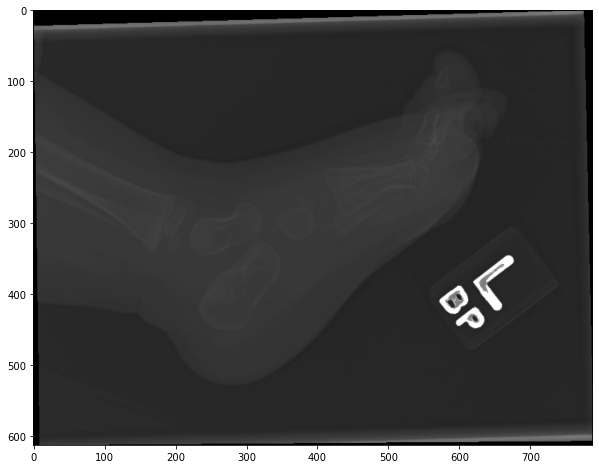

In [19]:
# 1: Angle between the:
# 1) Find the long axis of the talus
talus_data = axis_finder(talus)

# 2) Line between the midpoint of the talus and the 1st metatarsel
direction = two_point_unit(first_metatarsel, talus)

# Angle 
angle1 = angle_vector(direction, talus_data[:2])
print('The Talo-1st Metatarsel Angle is: {a:8.2f} degrees'.format(a = angle1))

# Plot
plt.rcParams['figure.figsize'] = [12, 8]
sub_plot(talus_data, 20, 
         ndimage.measurements.center_of_mass(talus)[1],
         ndimage.measurements.center_of_mass(talus)[0], 'red')
sub_plot(direction, 20, 
         ndimage.measurements.center_of_mass(talus)[1],
         ndimage.measurements.center_of_mass(talus)[0], 'red')

plt.rcParams['figure.figsize'] = [12, 8]
plt.imshow(nifti[0,], cmap='gray')
plt.gca()#.invert_yaxis()  # Match the image system with origin at top left
plt.show()

The Talus-calcaneal Angle is:    34.40 degrees


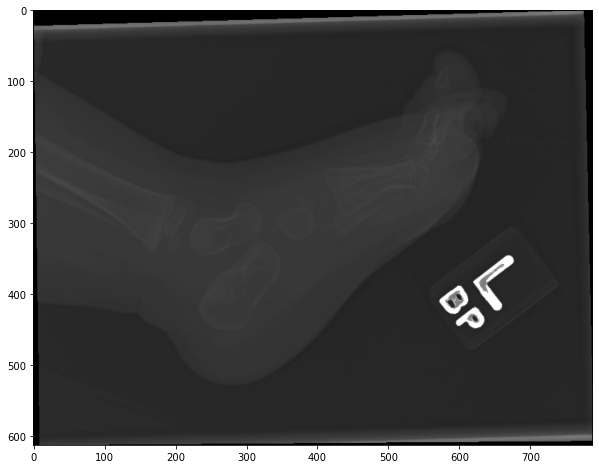

In [20]:
# 2: Angle between the:
# 1) Find the long axis of the talus
talus_data = axis_finder(talus)

# 2) Line between the midpoint of the talus and the 1st metatarsel
calcaneus_data = axis_finder(calcaneus)

# Angle 
angle1 = angle_vector(talus_data[:2], calcaneus_data[:2])
print('The Talus-calcaneal Angle is: {a:8.2f} degrees'.format(a = angle1))

# Plot
plt.rcParams['figure.figsize'] = [12, 8]
sub_plot(talus_data, 22, 
         ndimage.measurements.center_of_mass(calcaneus)[1],
         ndimage.measurements.center_of_mass(calcaneus)[0], 'red')
sub_plot(calcaneus_data, 22, 
         ndimage.measurements.center_of_mass(calcaneus)[1],
         ndimage.measurements.center_of_mass(calcaneus)[0], 'red')

plt.rcParams['figure.figsize'] = [12, 8]
plt.imshow(nifti[0,], cmap='gray')
plt.gca()#.invert_yaxis()  # Match the image system with origin at top left
plt.show()

In [21]:
# Find the line distance between the long axis on talus and passes through the cuboid
# 2: Angle between the:
# 1) Find the long axis of the talus
calcanues_data = axis_finder(calcaneus)

angle = math.degrees(math.atan(calcanues_data[1]/calcanues_data[0]))
radians = math.radians(angle + 90)
calcaneus_data_90 = [math.cos(radians), math.sin(radians)] # x, y

# 2) Find the midpoint of the cuboid
cuboid_cms = ndimage.measurements.center_of_mass(cuboid)

# Angle 
def shortest_distance(x1, y1, a, b, c):  
    d = abs((a * x1 + b * y1 + c)) / (math.sqrt(a * a + b * b)) 
    return d
    
pix_dist = shortest_distance(cuboid_cms[1], cuboid_cms[0], calcanues_data[0], calcanues_data[1], 0)

angle1 = angle_vector(calcanues_data[:2], clacaneus_data_90[:2])

print('The Talus-calcaneal Angle is: {a:8.2f} degrees'.format(a = angle1))
print("Perpendicular distance in pixels is", round(pix_dist, 2))
print("Perpendicular distance is", round((pix_dist * spacing[0]),3), 'mm')


# Plot

plt.rcParams['figure.figsize'] = [12, 8]
sub_plot(calcanues_data, 22, 
         ndimage.measurements.center_of_mass(calcaneus)[1],
         ndimage.measurements.center_of_mass(calcaneus)[0], 'red')

sub_plot(calcaneus_data_90, 15, 
         cuboid_cms[1],
         cuboid_cms[0], 'green')


plt.rcParams['figure.figsize'] = [12, 8]
plt.imshow(nifti[0,], cmap='gray')
plt.gca()#.invert_yaxis()  # Match the image system with origin at top left
plt.show()


NameError: name 'clacaneus_data_90' is not defined

## LAT View Radiograph Calcualtions

In [ ]:
# Picking a number to pull the ground truth data and dimensions
print('Pick a number between 0 -', len(validation_data))
num = 13
image = sitk.ReadImage(validation_data['nifti_path'].iloc[num])
spacing = image.GetSpacing() #0.1389 mm
print("The x, y resolution is %.2f" % spacing[0],", %.2f" % spacing[1] )
nifti = sitk.GetArrayViewFromImage(image)

vtk = sitk.ReadImage(validation_data['vtk_path'].iloc[num])
vtk_arr = sitk.GetArrayViewFromImage(vtk)
first_metatarsel, tibia, cuboid, calcaneus, talus = input_image(vtk_arr)

f, axarr = plt.subplots(1,2, figsize = (10,10)) 
axarr[0].imshow(nifti[0,], cmap='gray') # [0,]
axarr[1].imshow(vtk_arr, cmap='gray')

type_im = validation_data['nifti_path'].iloc[num].split('\\')[-1]
if 'AP' in type_im:
    print('AP Image')
if 'LAT' in type_im:
    print('LAT Image')

In [ ]:
# 1: Angle between the:
# 1) Find the long axis of the talus
talus_data = axis_finder(talus)

# 2) Line between the midpoint of the talus and the 1st metatarsel
direction = two_point_unit(first_metatarsel, talus)

# Angle 
angle1 = angle_vector(talus_data[:2], direction)
print('The Talus-calcaneal Angle is: {a:8.2f} degrees'.format(a = angle1))

# Plot
plt.rcParams['figure.figsize'] = [12, 8]
sub_plot(talus_data, 35, 
         ndimage.measurements.center_of_mass(talus)[1],
         ndimage.measurements.center_of_mass(talus)[0], 'red')
sub_plot(direction, 35, 
         ndimage.measurements.center_of_mass(talus)[1],
         ndimage.measurements.center_of_mass(talus)[0], 'red')

plt.rcParams['figure.figsize'] = [12, 8]
plt.imshow(nifti[0,], cmap='gray')
plt.gca()#.invert_yaxis()  # Match the image system with origin at top left
plt.show()

In [ ]:
print('Pick a number between 0 -', len(validation_data))
num = 13
image = sitk.ReadImage(validation_data['nifti_path'].iloc[num])
spacing = image.GetSpacing() #0.1389 mm
print("The x, y resolution is %.2f" % spacing[0],", %.2f" % spacing[1] )
nifti = sitk.GetArrayViewFromImage(image)

vtk = sitk.ReadImage(validation_data['vtk_path'].iloc[num])
vtk_arr = sitk.GetArrayViewFromImage(vtk)
first_metatarsel, tibia, cuboid, calcaneus, talus = input_image(vtk_arr)

f, axarr = plt.subplots(1,2, figsize = (10,10)) 
axarr[0].imshow(nifti[0,], cmap='gray') # [0,]
axarr[1].imshow(vtk_arr, cmap='gray')

type_im = validation_data['nifti_path'].iloc[num].split('\\')[-1]
if 'AP' in type_im:
    print('AP Image')
if 'LAT' in type_im:
    print('LAT Image')
    
LAT_calculations(nifti, vtk_arr, im_name, spacing, folder)

In [ ]:
# 2: Angle between the:
# 1) Find the long axis of the talus
talus_data = axis_finder(talus)

# 2) Line between the midpoint of the talus and the 1st metatarsel
calcaneus_data = axis_finder(calcaneus)

# Angle
angle2 = angle_vector(talus_data[:2], calcaneus_data[:2])
print('The 1st Metatarsal-Calcaneal Angle is: {a:8.2f} degrees'.format(a = angle2))

# Plot
plt.rcParams['figure.figsize'] = [12, 8]
sub_plot(talus_data, 50, 
         ndimage.measurements.center_of_mass(talus)[1],
         ndimage.measurements.center_of_mass(talus)[0], 'red')
sub_plot(calcaneus_data, 50, 
         ndimage.measurements.center_of_mass(calcaneus)[1],
         ndimage.measurements.center_of_mass(calcaneus)[0], 'red')

plt.rcParams['figure.figsize'] = [12, 8]
plt.imshow(nifti[0,], cmap='gray')
plt.gca()#.invert_yaxis()  # Match the image system with origin at top left
plt.show()

In [ ]:
# 1: Angle between the tibia and the calcaneus:
# 1) Find the long axis of the talus
tibia_data = axis_finder(tibia)

# 2) Line between the midpoint of the talus and the 1st metatarsel
calcaneus_data = axis_finder(calcaneus)

# Angle 
angle1 = angle_vector(tibia_data[:2], calcaneus_data[:2])
print('The Tbial-calcaneal Angle is: {a:8.2f} degrees'.format(a = angle1))

# Plot
plt.rcParams['figure.figsize'] = [12, 8]
sub_plot(tibia_data, 45, 
         ndimage.measurements.center_of_mass(calcaneus)[1],
         ndimage.measurements.center_of_mass(calcaneus)[0], 'red')
sub_plot(direction, 22, 
         ndimage.measurements.center_of_mass(calcaneus)[1],
         ndimage.measurements.center_of_mass(calcaneus)[0], 'red')

plt.rcParams['figure.figsize'] = [12, 8]
plt.imshow(nifti[0,], cmap='gray')
plt.gca()#.invert_yaxis()  # Match the image system with origin at top left
plt.show()